# UniversityHack 2021 - Atmira Stock Prediction - Script Producción
-----

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import keras
from keras import models
from keras import activations

from datetime import datetime
from matplotlib import pyplot as plt

from IPython.display import clear_output
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# If you plan to run this notebook, it is recomended you have at least one GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Preprocessing

Before we do anything with our data, we perform an extensive data preprocessing step according to our EDA findings:

1. Drop the `antiguedad` variable as we do not find it contains sensible data.
2. Change the dates to the correct year we estimate the data is from to match the weekday periodicity missmatch.
3. Scale the visitas x5 for the period preceding 2019-1-24 as we've found that it was tampered with.
4. One-hot encode several fields to improve ML performance
5. Augment our data with weekday and monthly sin/cos periodicty helpers. Will help the ML system detect periodic patterns.

We also run a price filling algorithm on the `Modelar` dataset to fill in the Price of items as specified in the instructions.

In [3]:
def data_preprocessing(df):
    # General cleaning
    df = df.drop_duplicates()
    df.dropna(how='any', inplace=True)
    df = df.drop(['antiguedad'], axis=1, errors='ignore')
    
    # Fix years
    df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
    df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
    
    # Fix visitas
    pre = df.fecha <= datetime(2019,1,24)
    post = df.fecha > datetime(2019,1,24)
    
    df['visitas_scl'] = np.concatenate([
        df[pre].visitas * 5,
        df[post].visitas * 1,
        ], axis=0
    )
    
    # Data Augmentation
    df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
    df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
    df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

    df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
    df['estado_transito'] = (df.estado == 'Transito').astype(int)
    df['estado_rotura'] = (df.estado == 'Rotura').astype(int)
    
    df['categoria_dos'] = df.categoria_dos.astype('str').str.replace('.0','')
    df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
    df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')
    
    df_fe = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)
    df_fe = df_fe.drop(['estado', 'dia_atipico', 'categoria_uno', 'categoria_dos'], axis=1, errors='ignore')
    
    # Cyclical week and month spinners
    df_weekday = df_fe.fecha.dt.weekday
    df_month = df_fe["fecha"].dt.month + (df_fe["fecha"].dt.day / df_fe["fecha"].dt.days_in_month)
    
    df_fe['weekday_sin'] = np.sin(df_weekday * (2*np.pi/7))
    df_fe['weekday_cos'] = np.cos(df_weekday * (2*np.pi/7))
    df_fe['month_sin'] = np.sin((df_month-1) * (2*np.pi/12))
    df_fe['month_cos'] = np.cos((df_month-1) * (2*np.pi/12))
    
    return df_fe

def data_preprocessing_fill_price(df):
    total = len(df.id.unique())

    for i, pid in enumerate(df.id.unique()):
        # This product's entries
        df_prod = df[df.id == pid]

        # Fillforward, then back to cover the first few lines
        df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

        # Save to DF
        df.loc[df_prod.index] = df_prod

        clear_output(wait=True)
        print("Filled %.1f%% of the Dataframe" % (i/total * 100))
        

In [ ]:
df_modelar = df_modelar = pd.read_csv(
    './data/Modelar_UH2021.txt', engine='python',
    sep='|', parse_dates=[0], dayfirst=True, decimal=','
)

print(df_modelar.shape)
df_modelar = data_preprocessing_fill_price(df_modelar)

In [ ]:
df_estimar = pd.read_csv('./data/Estimar2.txt', parse_dates=[0], sep='|', decimal=',', engine="python")
df_estimar = data_preprocessing(df_estimar)

print(df_estimar.shape)
df_estimar[:5]

## Select all columns that appear in both DataFrames

Since not all categories appear in `Estimar`, we perform a set intersect to grab the matching columns. After this we are finally ready to build our model.

In [ ]:
df_modelar_columns = set(df_modelar.columns)
df_estimar_columns = set(df_estimar.columns)
df_common_columns = df_modelar_columns & df_estimar_columns

# Reorder fecha to first column
df_common_columns.remove('fecha')

df_modelar = df_modelar[['fecha'] + list(df_common_columns) + ['unidades_vendidas']]
df_estimar = df_estimar[['fecha'] + list(df_common_columns)]

In [ ]:
df_modelar.to_csv('data/Modelar_UH2021_prod.txt', index=False)
df_estimar.to_csv('data/Estimar2_prod.txt', index=False)

In [29]:
df_modelar = pd.read_csv('data/Modelar_UH2021_prod.txt', parse_dates=[0])
df_estimar = pd.read_csv('data/Estimar2_prod.txt', parse_dates=[0], decimal=',')

# Keras Model

We will be using Keras to build a regression Neural Network to predict the target label. The steps will be as follows:

1. Determine the X and y columns
2. Split our data in Train / Test datasets wtih 0.9 / 0.1 weights
3. Transform our data to be easier for the NN to process
4. Sanity check our data before we proceed
5. Define the NN model to use:
    - Layer types
    - Number of neurons per layer
    - Output layer
    - Optimization function
    - Target loss
6. Execute the NN training on a GPU

## Train / Test Split

In [20]:
gc.collect()

7165

In [21]:
from sklearn.model_selection import train_test_split

X_cols = [
    'campaña',
    'dia_atipico_neg', 'dia_atipico_neu', 'dia_atipico_pos',
    'estado_rotura', 'estado_no_rotura', 'estado_transito',
    'precio', 'visitas_scl',
    'month_cos', 'month_sin',
    'weekday_cos', 'weekday_sin',
    
    'categoria_uno__A', 'categoria_uno__B', 'categoria_uno__C',
    'categoria_uno__D', 'categoria_uno__E', 'categoria_uno__F',
    'categoria_uno__G', 'categoria_uno__H', 'categoria_uno__I',
    'categoria_uno__K', 'categoria_uno__L', 'categoria_uno__N',
    'categoria_uno__O',

    'categoria_dos__114', 'categoria_dos__115', 'categoria_dos__116',
    'categoria_dos__122', 'categoria_dos__123', 'categoria_dos__124',
    'categoria_dos__125', 'categoria_dos__127', 'categoria_dos__131',
    'categoria_dos__133', 'categoria_dos__135', 'categoria_dos__136',
    'categoria_dos__137', 'categoria_dos__14', 'categoria_dos__143',
    'categoria_dos__144', 'categoria_dos__145', 'categoria_dos__155',
    'categoria_dos__156', 'categoria_dos__157', 'categoria_dos__158',
    'categoria_dos__16', 'categoria_dos__161', 'categoria_dos__165',
    'categoria_dos__174', 'categoria_dos__175', 'categoria_dos__179',
    'categoria_dos__182', 'categoria_dos__183', 'categoria_dos__186',
    'categoria_dos__188', 'categoria_dos__192', 'categoria_dos__195',
    'categoria_dos__197', 'categoria_dos__199', 'categoria_dos__2',
    'categoria_dos__212', 'categoria_dos__22', 'categoria_dos__221',
    'categoria_dos__223', 'categoria_dos__224', 'categoria_dos__226',
    'categoria_dos__228', 'categoria_dos__229', 'categoria_dos__23',
    'categoria_dos__233', 'categoria_dos__235', 'categoria_dos__236',
    'categoria_dos__237', 'categoria_dos__238', 'categoria_dos__239',
    'categoria_dos__243', 'categoria_dos__245', 'categoria_dos__247',
    'categoria_dos__248', 'categoria_dos__249', 'categoria_dos__253',
    'categoria_dos__255', 'categoria_dos__256', 'categoria_dos__258',
    'categoria_dos__259', 'categoria_dos__263', 'categoria_dos__264',
    'categoria_dos__266', 'categoria_dos__267', 'categoria_dos__268',
    'categoria_dos__269', 'categoria_dos__27', 'categoria_dos__271',
    'categoria_dos__274', 'categoria_dos__276', 'categoria_dos__277',
    'categoria_dos__278', 'categoria_dos__28', 'categoria_dos__285',
    'categoria_dos__286', 'categoria_dos__289', 'categoria_dos__29',
    'categoria_dos__292', 'categoria_dos__295', 'categoria_dos__296',
    'categoria_dos__298', 'categoria_dos__312', 'categoria_dos__314',
    'categoria_dos__315', 'categoria_dos__316', 'categoria_dos__319',
    'categoria_dos__32', 'categoria_dos__323', 'categoria_dos__326',
    'categoria_dos__329', 'categoria_dos__333', 'categoria_dos__336',
    'categoria_dos__338', 'categoria_dos__34', 'categoria_dos__341',
    'categoria_dos__342', 'categoria_dos__343', 'categoria_dos__36',
    'categoria_dos__37', 'categoria_dos__38', 'categoria_dos__39',
    'categoria_dos__42', 'categoria_dos__43', 'categoria_dos__44',
    'categoria_dos__45', 'categoria_dos__46', 'categoria_dos__49',
    'categoria_dos__5', 'categoria_dos__51', 'categoria_dos__57',
    'categoria_dos__63', 'categoria_dos__65', 'categoria_dos__66',
    'categoria_dos__67', 'categoria_dos__69', 'categoria_dos__7',
    'categoria_dos__71', 'categoria_dos__72', 'categoria_dos__73',
    'categoria_dos__75', 'categoria_dos__76', 'categoria_dos__78',
    'categoria_dos__8', 'categoria_dos__82', 'categoria_dos__84',
    'categoria_dos__85', 'categoria_dos__86', 'categoria_dos__92',
    'categoria_dos__93', 'categoria_dos__95', 'categoria_dos__97',
    'categoria_dos__282',
]

y_cols = ['unidades_vendidas']

X = df_modelar[X_cols]
y = df_modelar[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

## Fit Scalers to the Train data

In [22]:
from sklearn.preprocessing import RobustScaler

# X Scaling
X_scaler = RobustScaler(quantile_range=[5,95])

X_train_scl = X_train
X_test_scl = X_test

X_cols_to_std = ['precio', 'visitas_scl']

X_train_scl[X_cols_to_std] = X_scaler.fit_transform(X_train[X_cols_to_std])
X_test_scl[X_cols_to_std] = X_scaler.transform(X_test[X_cols_to_std])

# y scaling

y_scaler = RobustScaler(quantile_range=[5,95])

y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

In [9]:
# Inspect our data
X_train_scl.describe().round(2)

,campaña,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_rotura,estado_no_rotura,estado_transito,precio,visitas_scl,month_cos,...,categoria_dos__8,categoria_dos__82,categoria_dos__84,categoria_dos__85,categoria_dos__86,categoria_dos__92,categoria_dos__93,categoria_dos__95,categoria_dos__97,categoria_dos__282
count,1400222.00,1400222.00,1400222.00,1400222.0,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00,...,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00,1400222.00
mean,0.00,0.03,0.86,0.1,0.12,0.87,0.01,0.12,0.20,-0.18,...,0.00,0.06,0.01,0.01,0.01,0.00,0.00,0.00,0.01,0.01
std,0.07,0.18,0.34,0.3,0.32,0.33,0.11,0.33,1.27,0.70,...,0.04,0.24,0.07,0.12,0.07,0.04,0.05,0.02,0.08,0.07
min,0.00,0.00,0.00,0.0,0.00,0.00,0.00,-0.26,-0.07,-1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,-0.12,-0.05,-0.87,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.00,0.00,-0.34,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.27,0.13,0.49,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.0,1.00,1.00,1.00,2.17,211.98,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [10]:
# Visual inspection of y values
pd.concat([
    pd.Series(y_train[::13].values[:,0]),
    pd.Series(y_train_scl[::13][:,0]),
    pd.Series(y_scaler.inverse_transform(y_train_scl[::13])[:,0])
], axis=1)[::50]

,0,1,2
0,0,0.000000,0.0
50,0,0.000000,0.0
100,0,0.000000,0.0
150,0,0.000000,0.0
200,3,0.166667,3.0
...,...,...,...
107500,3,0.166667,3.0
107550,24,1.333333,24.0
107600,0,0.000000,0.0
107650,3,0.166667,3.0


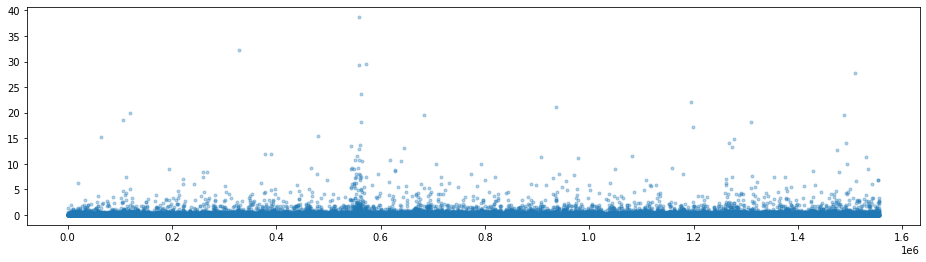

In [11]:
# Target variable spead
plt.figure(figsize=[16,4])
plt.scatter(X_train.index[::50], y_train_scl[::50], marker=".", alpha=0.33)

# NN Model

In [12]:
gc.collect()

20

In [ ]:
from keras.layers import Dense, Dropout, BatchNormalization

FEAT_DIM = len(X.columns)

gc.collect()

model = models.Sequential()

model.add(Dense(FEAT_DIM*8, input_dim=FEAT_DIM, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(FEAT_DIM*6, activation='relu'))
model.add(Dropout(0.1))

# model.add(BatchNormalization())
model.add(Dense(FEAT_DIM*5, activation='relu'))
model.add(Dense(FEAT_DIM*4, activation='relu'))
model.add(Dense(FEAT_DIM*3, activation='relu'))
model.add(Dense(FEAT_DIM*2, activation='relu'))
# model.add(Dense(FEAT_DIM*16, activation='relu'))
# OUTPUT
model.add(Dense(1, activation="linear"))


# Early Stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# es = keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=50)
# Store best model
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.compile(loss="mae", optimizer='adam', metrics=[])
model.summary()

In [ ]:
history = model.fit(X_train_scl, y_train_scl, epochs=1000, batch_size=200,
    callbacks=[es, mc],
    validation_data=(X_test_scl, y_test_scl)
)

## Plot the NN training results

This plot will help us identify if our NN is overfitting or if the training stalled. We can see a smooth curve downwards indicating our NN trained nicely.

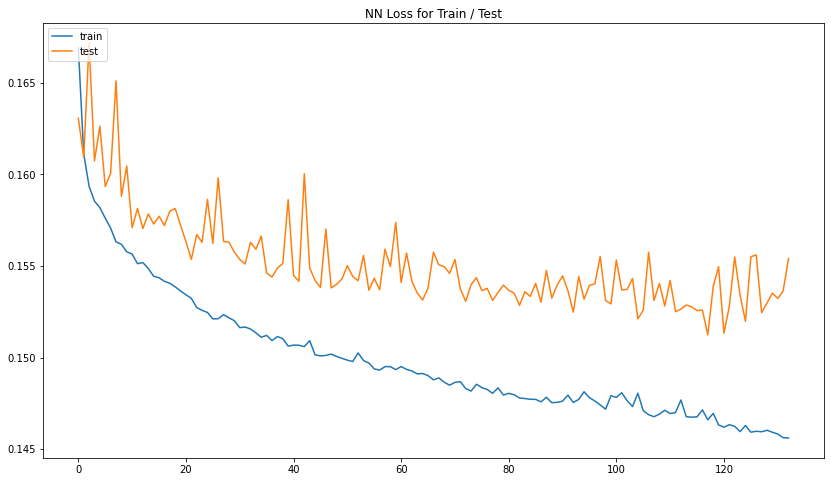

In [107]:
plt.figure(figsize=[14,8])
# plt.ylim((0.85,0.98))

plt.title('NN Loss for Train / Test')

train_acc = history.history['loss']
test_acc = history.history['val_loss']

plt.plot(train_acc)
plt.plot(test_acc)
# plt.plot([max(train_acc)] * len(train_acc))
# plt.plot([max(test_acc)] * len(test_acc))

plt.legend(['train', 'test'], loc='upper left')

## Model Scoring

Before we execute our model with the `Estimar` dataset, lets check the expected performance of our model. We want to center our attention to two aspects:

1. General predictive power across the entire year
2. Predictive score around the interest interval of Black friday and Christmas.
    - This will be the most correlated value to our expected `Estimar` score.

### Scoring Functions

These were defined in the documentation for this project.

In [23]:
def rrmse(y,yhat):
    return np.sqrt(np.sum(np.power(y-yhat,2))/y.shape[0])/y.mean()

def cf(y,yhat):
    no_rotura=np.where(yhat >= y, 1, 0)
    return no_rotura.mean()

def score(y,yhat):
    return (0.7*rrmse(y,yhat))+(.3*(1-cf(y,yhat)))

#### Use Trained model as is

In [ ]:
# trained_model = model
# y_hat = model.predict(X_test)
# y_hat_real = y_scaler.inverse_transform(y_hat)

#### Load Best model

In [13]:
from keras.models import load_model

best_model = load_model('2.2080 best_model - FINAL.h5', compile = False)

y_hat = best_model.predict(X_test)
y_hat_real = y_scaler.inverse_transform(y_hat)

### General error over the range

In [14]:
# Sum of real vs sum of prediction
y_test.sum().unidades_vendidas, (y_hat_real+1).sum()

(652917, 598548.4)

2.207968254271101

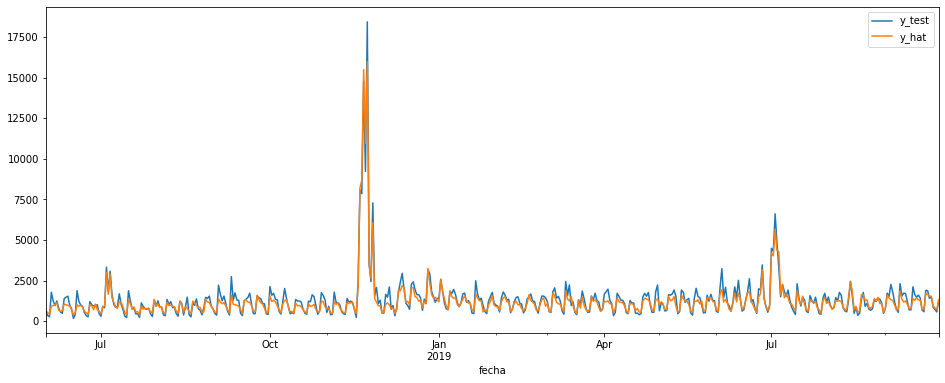

In [25]:
df_y_hat = pd.DataFrame()

df_y_hat['fecha'] = df_modelar.loc[X_test.index].fecha
# df_y_hat['visitas'] = X_test.visitas_scl
df_y_hat['y_test'] = y_test
df_y_hat['y_hat'] = ((y_hat_real * 1.0).round(0) ) + 1

df_y_hat.groupby('fecha').sum().plot(figsize=[16,6])

# y_hat_real += np.where(y_hat_real <= 0, 1, 1)
score(df_y_hat.y_test, df_y_hat.y_hat)

### Black Friday OOS Test

2.2465728019126163

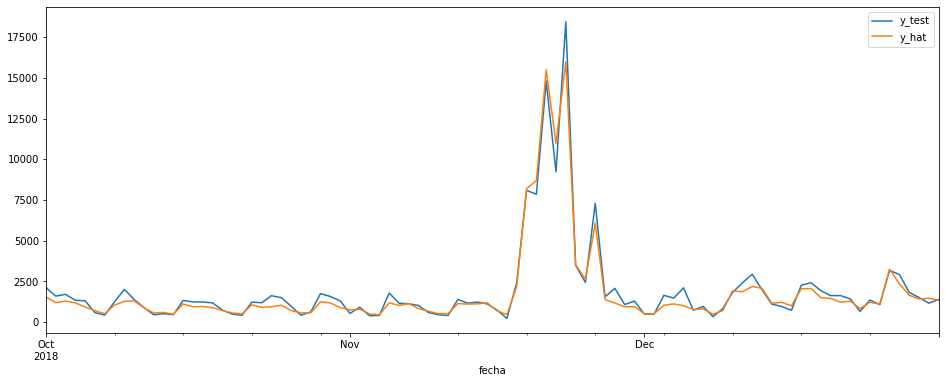

In [26]:
# Black friday dates
bf_index = (df_y_hat.fecha >= datetime(2018,10,1)) & (df_y_hat.fecha <= datetime(2018,12,31))

df_bf = df_y_hat[bf_index]
df_bf.groupby('fecha').sum().plot(figsize=[16,6])

score(df_bf.y_test, df_bf.y_hat)

# Generate final predictions

Apply the same transformations to the `Estimar` dataset to match the training data and generate predictions for it. We adjust the final output by +1 due to the `CF` factor.

In [30]:
X_estimar = df_estimar[X_cols]
X_estimar[X_cols_to_std] = X_scaler.transform(X_estimar[X_cols_to_std])

In [41]:
y_estimar = best_model.predict(X_estimar.astype(float))
y_estimar = y_scaler.inverse_transform(y_estimar)

y_estimar = y_estimar.round(0) + 1

In [50]:
df_entrega = df_estimar[['fecha','id']]
df_entrega['unidades'] = y_estimar.astype(int)

# df_entrega.loc[df_entrega.fecha.dt.year == 2019, "fecha"] = df_entrega.fecha + pd.offsets.DateOffset(year=2016)
df_entrega[:5]

,fecha,id,unidades
0,2019-10-01,21972,1
1,2019-10-02,21972,1
2,2019-10-03,21972,1
3,2019-10-04,21972,1
4,2019-10-05,21972,1


In [45]:
df_entrega

,fecha,id,unidades
0,2016-10-01,21972,1
1,2016-10-02,21972,1
2,2016-10-03,21972,1
3,2016-10-04,21972,1
4,2016-10-05,21972,1
...,...,...,...
212836,2016-12-26,458660,13
212837,2016-12-27,458660,9
212838,2016-12-28,458660,7
212839,2016-12-29,458660,4


In [65]:
mask = df_modelar.id.isin(df_estimar.id)

df_modelar_sameid.shape, df_modelar.shape

((1335090, 170), (1555803, 170))

In [76]:
df_modelar_fixed = df_modelar_sameid.groupby(['fecha','id']).max().reset_index()

<AxesSubplot:xlabel='fecha'>

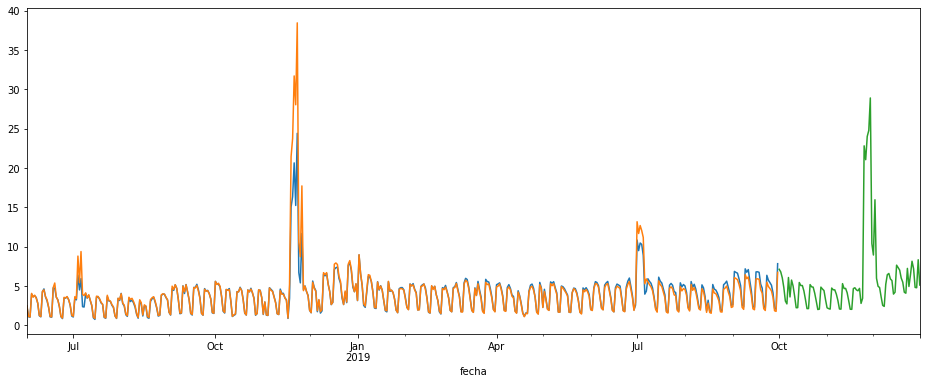

In [80]:
plt.figure(figsize=[16,6])

df_modelar_fixed.groupby('fecha').mean().unidades_vendidas.plot()
df_modelar.groupby('fecha').mean().unidades_vendidas.plot()
(df_entrega.groupby('fecha').mean().unidades *1).plot()

## Delivery CSV

In [105]:
df_entrega.columns = ['FECHA', 'ID', 'UNIDADES']
df_entrega.to_csv('data/Equip Autoestima.txt', sep='|', index=False, date_format="%d/%m/%Y")